# I. Intro to CatBoost


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost # Change here
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Quick Data Treatment

In [2]:
df = pd.read_csv('data/titanic.csv')

In [5]:
y = df['Survived']
X = df.copy()
X = X.drop(columns = ['Survived', 'Name'])
X.Sex = X.Sex.replace("male", 1)
X.Sex = X.Sex.replace("female", 2)

X["family_size"] = X["Siblings/Spouses Aboard"] + X["Parents/Children Aboard"]
X["single"] = (X["family_size"] == 0) * 1.0
X["elder"] =(X["Age"] > 60) * 1.0

Normalize the data X (optional)

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [7]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

This function is to show which featuree is important

In [8]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [9]:
def train_catboost(X_train, X_valid, y_train, y_valid, params=None):

    model = catboost.CatBoostClassifier(**params) # Change here
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], # Change here
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

List of CatBoost parameters: https://catboost.ai/docs/concepts/python-reference_parameters-list.html

In [10]:
params = { # Change here
          'n_estimators':5000,
          'max_depth': 4,
          'learning_rate': 0.02,
          'rsm': 0.8,
          'objective': 'Logloss'
         }

In [11]:
y_pred_train, y_pred_test, feature_importance = train_catboost(X_scaled_train, X_scaled_test, y_train, y_test, params=params) # Change here

0:	learn: 0.6804187	test: 0.6804187	test1: 0.6819501	best: 0.6819501 (0)	total: 54.2ms	remaining: 4m 31s
1:	learn: 0.6730310	test: 0.6730310	test1: 0.6750378	best: 0.6750378 (1)	total: 56.9ms	remaining: 2m 22s
2:	learn: 0.6617680	test: 0.6617680	test1: 0.6651138	best: 0.6651138 (2)	total: 61.2ms	remaining: 1m 41s
3:	learn: 0.6512635	test: 0.6512635	test1: 0.6557925	best: 0.6557925 (3)	total: 66.3ms	remaining: 1m 22s
4:	learn: 0.6415947	test: 0.6415947	test1: 0.6475298	best: 0.6475298 (4)	total: 70.1ms	remaining: 1m 10s
5:	learn: 0.6313149	test: 0.6313149	test1: 0.6380507	best: 0.6380507 (5)	total: 72.9ms	remaining: 1m
6:	learn: 0.6229838	test: 0.6229838	test1: 0.6309811	best: 0.6309811 (6)	total: 75.8ms	remaining: 54.1s
7:	learn: 0.6128971	test: 0.6128971	test1: 0.6220560	best: 0.6220560 (7)	total: 79.2ms	remaining: 49.4s
8:	learn: 0.6047662	test: 0.6047662	test1: 0.6147557	best: 0.6147557 (8)	total: 82ms	remaining: 45.5s
9:	learn: 0.5967034	test: 0.5967034	test1: 0.6076384	best: 0.607

91:	learn: 0.3954484	test: 0.3954484	test1: 0.4436932	best: 0.4436932 (91)	total: 422ms	remaining: 22.5s
92:	learn: 0.3948175	test: 0.3948175	test1: 0.4429019	best: 0.4429019 (92)	total: 426ms	remaining: 22.5s
93:	learn: 0.3943921	test: 0.3943921	test1: 0.4426164	best: 0.4426164 (93)	total: 430ms	remaining: 22.4s
94:	learn: 0.3941508	test: 0.3941508	test1: 0.4427324	best: 0.4426164 (93)	total: 434ms	remaining: 22.4s
95:	learn: 0.3937196	test: 0.3937196	test1: 0.4426190	best: 0.4426164 (93)	total: 437ms	remaining: 22.3s
96:	learn: 0.3930992	test: 0.3930992	test1: 0.4424155	best: 0.4424155 (96)	total: 441ms	remaining: 22.3s
97:	learn: 0.3924220	test: 0.3924220	test1: 0.4415509	best: 0.4415509 (97)	total: 444ms	remaining: 22.2s
98:	learn: 0.3918541	test: 0.3918541	test1: 0.4412136	best: 0.4412136 (98)	total: 447ms	remaining: 22.1s
99:	learn: 0.3917112	test: 0.3917112	test1: 0.4412690	best: 0.4412136 (98)	total: 450ms	remaining: 22s
100:	learn: 0.3909531	test: 0.3909531	test1: 0.4407969	be

193:	learn: 0.3627500	test: 0.3627500	test1: 0.4292655	best: 0.4292655 (193)	total: 804ms	remaining: 19.9s
194:	learn: 0.3625559	test: 0.3625559	test1: 0.4291494	best: 0.4291494 (194)	total: 807ms	remaining: 19.9s
195:	learn: 0.3621291	test: 0.3621291	test1: 0.4291323	best: 0.4291323 (195)	total: 810ms	remaining: 19.8s
196:	learn: 0.3619195	test: 0.3619195	test1: 0.4291550	best: 0.4291323 (195)	total: 813ms	remaining: 19.8s
197:	learn: 0.3617108	test: 0.3617108	test1: 0.4292158	best: 0.4291323 (195)	total: 819ms	remaining: 19.9s
198:	learn: 0.3614187	test: 0.3614187	test1: 0.4290332	best: 0.4290332 (198)	total: 822ms	remaining: 19.8s
199:	learn: 0.3612705	test: 0.3612705	test1: 0.4289770	best: 0.4289770 (199)	total: 827ms	remaining: 19.8s
200:	learn: 0.3611298	test: 0.3611298	test1: 0.4290353	best: 0.4289770 (199)	total: 830ms	remaining: 19.8s
201:	learn: 0.3609038	test: 0.3609038	test1: 0.4288080	best: 0.4288080 (201)	total: 838ms	remaining: 19.9s
202:	learn: 0.3607385	test: 0.3607385

In [12]:
train_acc = sum(y_train == y_pred_train)/len(y_train)
train_acc

0.8561354019746121

In [13]:
test_acc = sum(y_test == y_pred_test)/len(y_test)
test_acc

0.8314606741573034

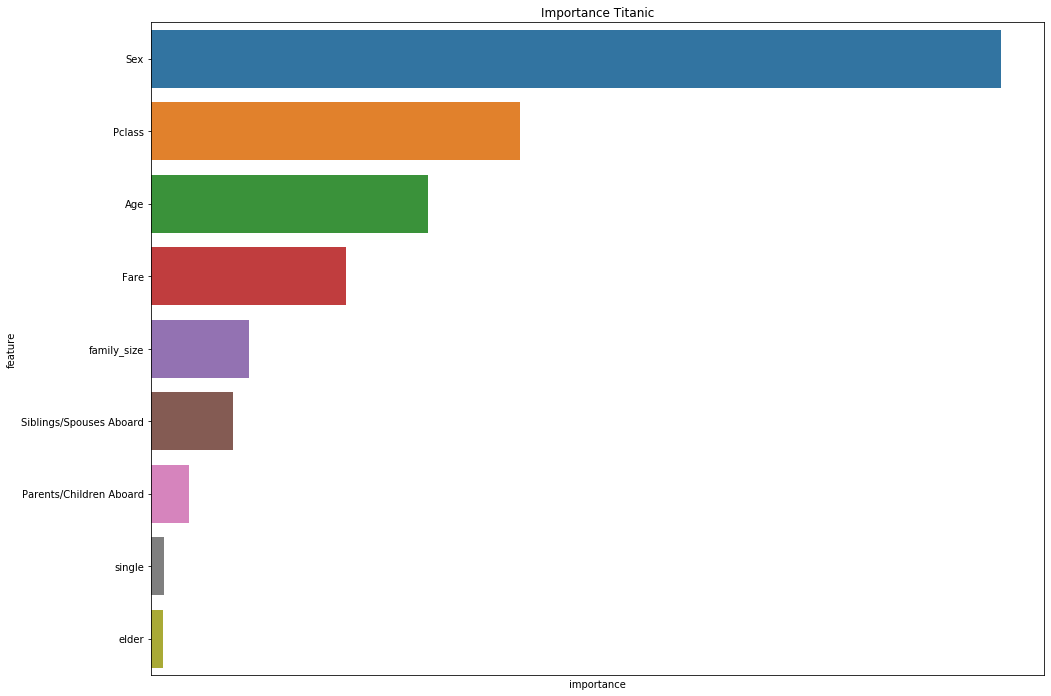

In [14]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Retrain without rescale X to see anything different

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_catboost(X_train, X_test, y_train, y_test, params=params)

0:	learn: 0.6804187	test: 0.6804187	test1: 0.6819501	best: 0.6819501 (0)	total: 3.02ms	remaining: 15.1s
1:	learn: 0.6730310	test: 0.6730310	test1: 0.6750378	best: 0.6750378 (1)	total: 5.85ms	remaining: 14.6s
2:	learn: 0.6617680	test: 0.6617680	test1: 0.6651138	best: 0.6651138 (2)	total: 10ms	remaining: 16.7s
3:	learn: 0.6512635	test: 0.6512635	test1: 0.6557925	best: 0.6557925 (3)	total: 13.4ms	remaining: 16.7s
4:	learn: 0.6415947	test: 0.6415947	test1: 0.6475298	best: 0.6475298 (4)	total: 17.1ms	remaining: 17.1s
5:	learn: 0.6313149	test: 0.6313149	test1: 0.6380507	best: 0.6380507 (5)	total: 19.9ms	remaining: 16.6s
6:	learn: 0.6229838	test: 0.6229838	test1: 0.6309811	best: 0.6309811 (6)	total: 28.6ms	remaining: 20.4s
7:	learn: 0.6128971	test: 0.6128971	test1: 0.6220560	best: 0.6220560 (7)	total: 33.4ms	remaining: 20.9s
8:	learn: 0.6047662	test: 0.6047662	test1: 0.6147557	best: 0.6147557 (8)	total: 37ms	remaining: 20.5s
9:	learn: 0.5967034	test: 0.5967034	test1: 0.6076384	best: 0.6076384

107:	learn: 0.3870715	test: 0.3870715	test1: 0.4383063	best: 0.4382669 (106)	total: 365ms	remaining: 16.5s
108:	learn: 0.3867871	test: 0.3867871	test1: 0.4377794	best: 0.4377794 (108)	total: 373ms	remaining: 16.7s
109:	learn: 0.3864100	test: 0.3864100	test1: 0.4375948	best: 0.4375948 (109)	total: 376ms	remaining: 16.7s
110:	learn: 0.3859906	test: 0.3859906	test1: 0.4376614	best: 0.4375948 (109)	total: 379ms	remaining: 16.7s
111:	learn: 0.3853999	test: 0.3853999	test1: 0.4371677	best: 0.4371677 (111)	total: 381ms	remaining: 16.6s
112:	learn: 0.3849077	test: 0.3849077	test1: 0.4368214	best: 0.4368214 (112)	total: 384ms	remaining: 16.6s
113:	learn: 0.3843749	test: 0.3843749	test1: 0.4363769	best: 0.4363769 (113)	total: 390ms	remaining: 16.7s
114:	learn: 0.3840451	test: 0.3840451	test1: 0.4362438	best: 0.4362438 (114)	total: 393ms	remaining: 16.7s
115:	learn: 0.3836077	test: 0.3836077	test1: 0.4355785	best: 0.4355785 (115)	total: 396ms	remaining: 16.7s
116:	learn: 0.3830799	test: 0.3830799

222:	learn: 0.3571466	test: 0.3571466	test1: 0.4276142	best: 0.4275912 (221)	total: 734ms	remaining: 15.7s
223:	learn: 0.3570669	test: 0.3570669	test1: 0.4276015	best: 0.4275912 (221)	total: 738ms	remaining: 15.7s
224:	learn: 0.3569143	test: 0.3569143	test1: 0.4276560	best: 0.4275912 (221)	total: 741ms	remaining: 15.7s
225:	learn: 0.3568220	test: 0.3568220	test1: 0.4276133	best: 0.4275912 (221)	total: 746ms	remaining: 15.8s
226:	learn: 0.3567380	test: 0.3567380	test1: 0.4275755	best: 0.4275755 (226)	total: 750ms	remaining: 15.8s
227:	learn: 0.3565970	test: 0.3565970	test1: 0.4277047	best: 0.4275755 (226)	total: 754ms	remaining: 15.8s
228:	learn: 0.3564041	test: 0.3564041	test1: 0.4276493	best: 0.4275755 (226)	total: 757ms	remaining: 15.8s
229:	learn: 0.3562240	test: 0.3562240	test1: 0.4273617	best: 0.4273617 (229)	total: 760ms	remaining: 15.8s
230:	learn: 0.3560371	test: 0.3560371	test1: 0.4273489	best: 0.4273489 (230)	total: 764ms	remaining: 15.8s
231:	learn: 0.3558085	test: 0.3558085

**Exercise:** Try tuning, adding, removing params.
    
List of CatBoost parameters: https://catboost.ai/docs/concepts/python-reference_parameters-list.html

In [33]:
params = { # Change here
          'n_estimators':5000,
          'max_depth': 4,
          'learning_rate': 0.02,
          'rsm': 0.8,
          'objective': 'Logloss'
         }

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_catboost(X_train, X_test, y_train, y_test, params=params)

0:	learn: 0.6804187	test: 0.6804187	test1: 0.6819501	best: 0.6819501 (0)	total: 3.99ms	remaining: 19.9s
1:	learn: 0.6730310	test: 0.6730310	test1: 0.6750378	best: 0.6750378 (1)	total: 6.54ms	remaining: 16.4s
2:	learn: 0.6617680	test: 0.6617680	test1: 0.6651138	best: 0.6651138 (2)	total: 12.3ms	remaining: 20.5s
3:	learn: 0.6512635	test: 0.6512635	test1: 0.6557925	best: 0.6557925 (3)	total: 15.3ms	remaining: 19.1s
4:	learn: 0.6415947	test: 0.6415947	test1: 0.6475298	best: 0.6475298 (4)	total: 18.3ms	remaining: 18.2s
5:	learn: 0.6313149	test: 0.6313149	test1: 0.6380507	best: 0.6380507 (5)	total: 21ms	remaining: 17.4s
6:	learn: 0.6229838	test: 0.6229838	test1: 0.6309811	best: 0.6309811 (6)	total: 24ms	remaining: 17.1s
7:	learn: 0.6128971	test: 0.6128971	test1: 0.6220560	best: 0.6220560 (7)	total: 28.5ms	remaining: 17.8s
8:	learn: 0.6047662	test: 0.6047662	test1: 0.6147557	best: 0.6147557 (8)	total: 32.9ms	remaining: 18.2s
9:	learn: 0.5967034	test: 0.5967034	test1: 0.6076384	best: 0.6076384

80:	learn: 0.4023163	test: 0.4023163	test1: 0.4477722	best: 0.4477722 (80)	total: 364ms	remaining: 22.1s
81:	learn: 0.4016443	test: 0.4016443	test1: 0.4474108	best: 0.4474108 (81)	total: 368ms	remaining: 22.1s
82:	learn: 0.4013356	test: 0.4013356	test1: 0.4473349	best: 0.4473349 (82)	total: 373ms	remaining: 22.1s
83:	learn: 0.4006283	test: 0.4006283	test1: 0.4468174	best: 0.4468174 (83)	total: 380ms	remaining: 22.2s
84:	learn: 0.3996852	test: 0.3996852	test1: 0.4458165	best: 0.4458165 (84)	total: 383ms	remaining: 22.2s
85:	learn: 0.3989586	test: 0.3989586	test1: 0.4452983	best: 0.4452983 (85)	total: 389ms	remaining: 22.2s
86:	learn: 0.3982923	test: 0.3982923	test1: 0.4451205	best: 0.4451205 (86)	total: 397ms	remaining: 22.4s
87:	learn: 0.3975679	test: 0.3975679	test1: 0.4449219	best: 0.4449219 (87)	total: 405ms	remaining: 22.6s
88:	learn: 0.3974004	test: 0.3974004	test1: 0.4448988	best: 0.4448988 (88)	total: 408ms	remaining: 22.5s
89:	learn: 0.3966805	test: 0.3966805	test1: 0.4442336	b

182:	learn: 0.3648436	test: 0.3648436	test1: 0.4306657	best: 0.4299382 (168)	total: 738ms	remaining: 19.4s
183:	learn: 0.3645514	test: 0.3645514	test1: 0.4302605	best: 0.4299382 (168)	total: 742ms	remaining: 19.4s
184:	learn: 0.3643871	test: 0.3643871	test1: 0.4302672	best: 0.4299382 (168)	total: 746ms	remaining: 19.4s
185:	learn: 0.3643112	test: 0.3643112	test1: 0.4301662	best: 0.4299382 (168)	total: 748ms	remaining: 19.4s
186:	learn: 0.3642381	test: 0.3642381	test1: 0.4301329	best: 0.4299382 (168)	total: 752ms	remaining: 19.4s
187:	learn: 0.3641047	test: 0.3641047	test1: 0.4301620	best: 0.4299382 (168)	total: 760ms	remaining: 19.4s
188:	learn: 0.3638564	test: 0.3638564	test1: 0.4298479	best: 0.4298479 (188)	total: 765ms	remaining: 19.5s
189:	learn: 0.3637640	test: 0.3637640	test1: 0.4299260	best: 0.4298479 (188)	total: 770ms	remaining: 19.5s
190:	learn: 0.3636264	test: 0.3636264	test1: 0.4300002	best: 0.4298479 (188)	total: 776ms	remaining: 19.5s
191:	learn: 0.3632562	test: 0.3632562

280:	learn: 0.3475046	test: 0.3475046	test1: 0.4266863	best: 0.4263113 (248)	total: 1.11s	remaining: 18.7s
281:	learn: 0.3473865	test: 0.3473865	test1: 0.4266959	best: 0.4263113 (248)	total: 1.12s	remaining: 18.7s
282:	learn: 0.3472757	test: 0.3472757	test1: 0.4267685	best: 0.4263113 (248)	total: 1.12s	remaining: 18.7s
283:	learn: 0.3471644	test: 0.3471644	test1: 0.4266589	best: 0.4263113 (248)	total: 1.13s	remaining: 18.7s
284:	learn: 0.3471312	test: 0.3471312	test1: 0.4266739	best: 0.4263113 (248)	total: 1.13s	remaining: 18.7s
285:	learn: 0.3470538	test: 0.3470538	test1: 0.4267274	best: 0.4263113 (248)	total: 1.14s	remaining: 18.7s
286:	learn: 0.3467545	test: 0.3467545	test1: 0.4273509	best: 0.4263113 (248)	total: 1.14s	remaining: 18.7s
287:	learn: 0.3465188	test: 0.3465188	test1: 0.4272807	best: 0.4263113 (248)	total: 1.14s	remaining: 18.7s
288:	learn: 0.3464871	test: 0.3464871	test1: 0.4272762	best: 0.4263113 (248)	total: 1.15s	remaining: 18.7s
289:	learn: 0.3463939	test: 0.3463939

**Exercise:** Try creating new features, or removing unimportant features

In [35]:
y = df.Survived
X = df.copy()

X.Sex = X.Sex.replace("male", 1)
X.Sex = X.Sex.replace("female", 2)

X["elder"] =(X["Age"] > 60) * 1.0
X["child"] = (X["Age"] < 18) * 1.0
X["family_size"] = X["Siblings/Spouses Aboard"] + X["Parents/Children Aboard"]
X["single"] = (X["family_size"] == 0) * 1.0
X = X.drop(columns=["Name", "Age", "Fare", "Survived"])

In [36]:
X.columns

Index(['Pclass', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard',
       'elder', 'child', 'family_size', 'single'],
      dtype='object')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_catboost(X_train, X_test, y_train, y_test, params=params)

0:	learn: 0.6809976	test: 0.6809976	test1: 0.6821877	best: 0.6821877 (0)	total: 3.88ms	remaining: 19.4s
1:	learn: 0.6697083	test: 0.6697083	test1: 0.6721377	best: 0.6721377 (1)	total: 7.64ms	remaining: 19.1s
2:	learn: 0.6581307	test: 0.6581307	test1: 0.6613274	best: 0.6613274 (2)	total: 10.5ms	remaining: 17.5s
3:	learn: 0.6474293	test: 0.6474293	test1: 0.6522288	best: 0.6522288 (3)	total: 13.7ms	remaining: 17.1s
4:	learn: 0.6373982	test: 0.6373982	test1: 0.6434782	best: 0.6434782 (4)	total: 17ms	remaining: 17s
5:	learn: 0.6313029	test: 0.6313029	test1: 0.6378852	best: 0.6378852 (5)	total: 19.8ms	remaining: 16.5s
6:	learn: 0.6245056	test: 0.6245056	test1: 0.6320752	best: 0.6320752 (6)	total: 23.7ms	remaining: 16.9s
7:	learn: 0.6151327	test: 0.6151327	test1: 0.6237285	best: 0.6237285 (7)	total: 27ms	remaining: 16.8s
8:	learn: 0.6064623	test: 0.6064623	test1: 0.6161641	best: 0.6161641 (8)	total: 29.5ms	remaining: 16.4s
9:	learn: 0.5977643	test: 0.5977643	test1: 0.6080140	best: 0.6080140 (

105:	learn: 0.4090257	test: 0.4090257	test1: 0.4510793	best: 0.4510090 (104)	total: 365ms	remaining: 16.8s
106:	learn: 0.4083557	test: 0.4083557	test1: 0.4503527	best: 0.4503527 (106)	total: 368ms	remaining: 16.8s
107:	learn: 0.4081264	test: 0.4081264	test1: 0.4503057	best: 0.4503057 (107)	total: 372ms	remaining: 16.8s
108:	learn: 0.4077946	test: 0.4077946	test1: 0.4500668	best: 0.4500668 (108)	total: 377ms	remaining: 16.9s
109:	learn: 0.4077029	test: 0.4077029	test1: 0.4500229	best: 0.4500229 (109)	total: 382ms	remaining: 17s
110:	learn: 0.4074590	test: 0.4074590	test1: 0.4497420	best: 0.4497420 (110)	total: 386ms	remaining: 17s
111:	learn: 0.4072811	test: 0.4072811	test1: 0.4497711	best: 0.4497420 (110)	total: 398ms	remaining: 17.4s
112:	learn: 0.4069717	test: 0.4069717	test1: 0.4496988	best: 0.4496988 (112)	total: 405ms	remaining: 17.5s
113:	learn: 0.4067489	test: 0.4067489	test1: 0.4496669	best: 0.4496669 (113)	total: 412ms	remaining: 17.6s
114:	learn: 0.4065962	test: 0.4065962	tes

235:	learn: 0.3878467	test: 0.3878467	test1: 0.4394021	best: 0.4393208 (231)	total: 729ms	remaining: 14.7s
236:	learn: 0.3876861	test: 0.3876861	test1: 0.4391824	best: 0.4391824 (236)	total: 735ms	remaining: 14.8s
237:	learn: 0.3876449	test: 0.3876449	test1: 0.4391837	best: 0.4391824 (236)	total: 743ms	remaining: 14.9s
238:	learn: 0.3875940	test: 0.3875940	test1: 0.4392296	best: 0.4391824 (236)	total: 746ms	remaining: 14.9s
239:	learn: 0.3875497	test: 0.3875497	test1: 0.4392067	best: 0.4391824 (236)	total: 749ms	remaining: 14.8s
240:	learn: 0.3874840	test: 0.3874840	test1: 0.4392541	best: 0.4391824 (236)	total: 751ms	remaining: 14.8s
241:	learn: 0.3874310	test: 0.3874310	test1: 0.4391607	best: 0.4391607 (241)	total: 754ms	remaining: 14.8s
242:	learn: 0.3873504	test: 0.3873504	test1: 0.4392235	best: 0.4391607 (241)	total: 757ms	remaining: 14.8s
243:	learn: 0.3873457	test: 0.3873457	test1: 0.4392513	best: 0.4391607 (241)	total: 759ms	remaining: 14.8s
244:	learn: 0.3872841	test: 0.3872841

351:	learn: 0.3796484	test: 0.3796484	test1: 0.4365484	best: 0.4365484 (351)	total: 1.11s	remaining: 14.6s
352:	learn: 0.3795951	test: 0.3795951	test1: 0.4366230	best: 0.4365484 (351)	total: 1.11s	remaining: 14.6s
353:	learn: 0.3795562	test: 0.3795562	test1: 0.4365851	best: 0.4365484 (351)	total: 1.11s	remaining: 14.6s
354:	learn: 0.3795186	test: 0.3795186	test1: 0.4365789	best: 0.4365484 (351)	total: 1.13s	remaining: 14.7s
355:	learn: 0.3793678	test: 0.3793678	test1: 0.4364149	best: 0.4364149 (355)	total: 1.13s	remaining: 14.7s
356:	learn: 0.3793204	test: 0.3793204	test1: 0.4364004	best: 0.4364004 (356)	total: 1.13s	remaining: 14.8s
357:	learn: 0.3792040	test: 0.3792040	test1: 0.4363033	best: 0.4363033 (357)	total: 1.15s	remaining: 14.9s
358:	learn: 0.3791549	test: 0.3791549	test1: 0.4362963	best: 0.4362963 (358)	total: 1.16s	remaining: 15s
359:	learn: 0.3790708	test: 0.3790708	test1: 0.4363043	best: 0.4362963 (358)	total: 1.17s	remaining: 15s
360:	learn: 0.3789762	test: 0.3789762	tes

434:	learn: 0.3744442	test: 0.3744442	test1: 0.4351115	best: 0.4350358 (424)	total: 1.47s	remaining: 15.5s
435:	learn: 0.3744018	test: 0.3744018	test1: 0.4350976	best: 0.4350358 (424)	total: 1.48s	remaining: 15.5s
436:	learn: 0.3742906	test: 0.3742906	test1: 0.4350704	best: 0.4350358 (424)	total: 1.48s	remaining: 15.5s
437:	learn: 0.3742550	test: 0.3742550	test1: 0.4350491	best: 0.4350358 (424)	total: 1.49s	remaining: 15.5s
438:	learn: 0.3742236	test: 0.3742236	test1: 0.4350561	best: 0.4350358 (424)	total: 1.49s	remaining: 15.5s
439:	learn: 0.3741736	test: 0.3741736	test1: 0.4350230	best: 0.4350230 (439)	total: 1.5s	remaining: 15.5s
440:	learn: 0.3741390	test: 0.3741390	test1: 0.4350459	best: 0.4350230 (439)	total: 1.5s	remaining: 15.5s
441:	learn: 0.3740875	test: 0.3740875	test1: 0.4350595	best: 0.4350230 (439)	total: 1.51s	remaining: 15.6s
442:	learn: 0.3739817	test: 0.3739817	test1: 0.4350545	best: 0.4350230 (439)	total: 1.52s	remaining: 15.6s
443:	learn: 0.3739119	test: 0.3739119	t

532:	learn: 0.3700409	test: 0.3700409	test1: 0.4337465	best: 0.4337465 (532)	total: 1.84s	remaining: 15.4s
533:	learn: 0.3700084	test: 0.3700084	test1: 0.4338032	best: 0.4337465 (532)	total: 1.84s	remaining: 15.4s
534:	learn: 0.3699944	test: 0.3699944	test1: 0.4337926	best: 0.4337465 (532)	total: 1.84s	remaining: 15.4s
535:	learn: 0.3699282	test: 0.3699282	test1: 0.4337961	best: 0.4337465 (532)	total: 1.85s	remaining: 15.4s
536:	learn: 0.3698843	test: 0.3698843	test1: 0.4338114	best: 0.4337465 (532)	total: 1.85s	remaining: 15.4s
537:	learn: 0.3698699	test: 0.3698699	test1: 0.4338302	best: 0.4337465 (532)	total: 1.85s	remaining: 15.4s
538:	learn: 0.3698353	test: 0.3698353	test1: 0.4338172	best: 0.4337465 (532)	total: 1.86s	remaining: 15.4s
539:	learn: 0.3697900	test: 0.3697900	test1: 0.4337697	best: 0.4337465 (532)	total: 1.86s	remaining: 15.4s
540:	learn: 0.3697714	test: 0.3697714	test1: 0.4337932	best: 0.4337465 (532)	total: 1.86s	remaining: 15.3s
541:	learn: 0.3697574	test: 0.3697574

645:	learn: 0.3656266	test: 0.3656266	test1: 0.4330908	best: 0.4330908 (645)	total: 2.2s	remaining: 14.8s
646:	learn: 0.3655636	test: 0.3655636	test1: 0.4330822	best: 0.4330822 (646)	total: 2.2s	remaining: 14.8s
647:	learn: 0.3655337	test: 0.3655337	test1: 0.4330825	best: 0.4330822 (646)	total: 2.21s	remaining: 14.8s
648:	learn: 0.3655267	test: 0.3655267	test1: 0.4330610	best: 0.4330610 (648)	total: 2.21s	remaining: 14.8s
649:	learn: 0.3655079	test: 0.3655079	test1: 0.4330037	best: 0.4330037 (649)	total: 2.22s	remaining: 14.8s
650:	learn: 0.3654926	test: 0.3654926	test1: 0.4329969	best: 0.4329969 (650)	total: 2.22s	remaining: 14.8s
651:	learn: 0.3654482	test: 0.3654482	test1: 0.4329995	best: 0.4329969 (650)	total: 2.22s	remaining: 14.8s
652:	learn: 0.3654420	test: 0.3654420	test1: 0.4330022	best: 0.4329969 (650)	total: 2.23s	remaining: 14.8s
653:	learn: 0.3654337	test: 0.3654337	test1: 0.4329954	best: 0.4329954 (653)	total: 2.23s	remaining: 14.8s
654:	learn: 0.3654283	test: 0.3654283	t

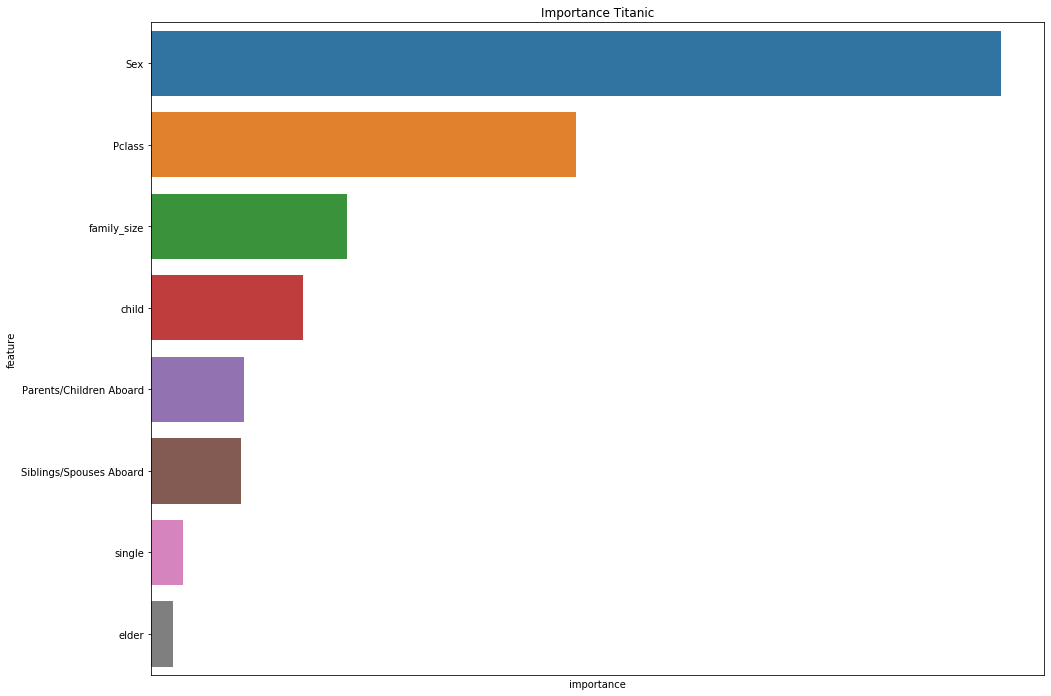

In [39]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')